In [2]:
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
from sklearn.dummy import DummyClassifier
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


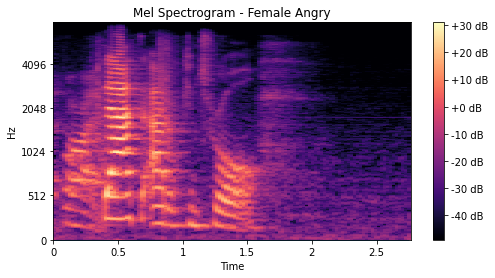

In [3]:
x, sr = librosa.load('/content/drive/MyDrive/iemowav/anger/Ses01F_impro01_F012.wav')
plt.figure(figsize=(8, 4))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Female Angry')
plt.savefig('Waveplot_FemaleAngry.png')
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=256,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Female Angry')
plt.savefig('MelSpec_FemaleAngry.png')
plt.set_cmap('magma')
plt.colorbar(format='%+2.0f dB')

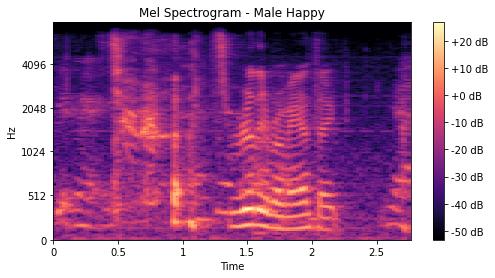

In [4]:
x, sr = librosa.load('/content/drive/MyDrive/iemowav/happiness/Ses01F_impro03_M007.wav')
plt.figure(figsize=(8, 4))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Male Happy')
plt.savefig('Waveplot_MaleHappy.png')
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=256,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Male Happy')
plt.savefig('MelSpec_MaleHappy.png')
plt.set_cmap('magma')
plt.colorbar(format='%+2.0f dB')

In [5]:
audio = "/content/drive/MyDrive/iemowav/"
emot_folders = os.listdir(audio)
emot_folders.sort() 
emot_folders

['anger', 'happiness', 'neutral', 'sadness']

In [6]:
emotion = []
gender = []
file_path = []
for i in emot_folders:
    filename = os.listdir(audio + i)
    for f in filename:
        if (i == "neutral"):
            emotion.append(1)
        elif (i == "anger"):
            emotion.append(4)
        elif (i == "sadness"):
            emotion.append(3)
        elif (i == "happiness"):
            emotion.append(2)
        if (f[5] == 'F'):
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(audio + i + '/' + f)
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'happy', 3:'sad', 4:'angry'})
audio_df = pd.concat([pd.DataFrame(gender),audio_df,],axis=1)
audio_df.columns = ['gender','emotion']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
audio_df

,gender,emotion,path
0,male,angry,/content/drive/MyDrive/iemowav/anger/Ses01M_sc...
1,male,angry,/content/drive/MyDrive/iemowav/anger/Ses01M_sc...
2,male,angry,/content/drive/MyDrive/iemowav/anger/Ses01M_sc...
3,male,angry,/content/drive/MyDrive/iemowav/anger/Ses01M_sc...
4,male,angry,/content/drive/MyDrive/iemowav/anger/Ses01M_sc...
...,...,...,...
4348,female,sad,/content/drive/MyDrive/iemowav/sadness/Ses01F_...
4349,female,sad,/content/drive/MyDrive/iemowav/sadness/Ses01F_...
4350,female,sad,/content/drive/MyDrive/iemowav/sadness/Ses01F_...
4351,female,sad,/content/drive/MyDrive/iemowav/sadness/Ses01F_...


In [7]:
pd.set_option('display.max_colwidth', -1)
audio_df.sample(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,gender,emotion,path
2876,female,neutral,/content/drive/MyDrive/iemowav/neutral/Ses01F_impro04_M002.wav
3962,female,sad,/content/drive/MyDrive/iemowav/sadness/Ses04F_script01_3_M036.wav
1570,male,happy,/content/drive/MyDrive/iemowav/happiness/Ses05M_impro03_F017.wav
2369,male,neutral,/content/drive/MyDrive/iemowav/neutral/Ses05M_impro08_M027.wav
1265,male,happy,/content/drive/MyDrive/iemowav/happiness/Ses02M_impro07_F028.wav
1857,male,neutral,/content/drive/MyDrive/iemowav/neutral/Ses03M_impro08b_M017.wav
1182,female,happy,/content/drive/MyDrive/iemowav/happiness/Ses01F_script01_3_F021.wav
1326,female,happy,/content/drive/MyDrive/iemowav/happiness/Ses02F_script03_1_F008.wav
3631,male,sad,/content/drive/MyDrive/iemowav/sadness/Ses02M_impro06_M006.wav
1848,male,neutral,/content/drive/MyDrive/iemowav/neutral/Ses03M_script01_1_M038.wav


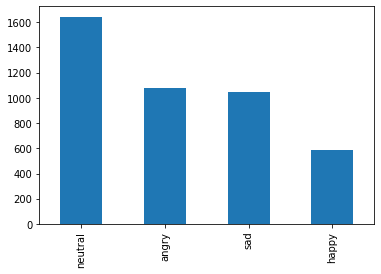

In [8]:
audio_df.emotion.value_counts().plot(kind='bar')

In [11]:
df = pd.DataFrame(columns=['mel_spectrogram'])
for index, path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=5,sr=22050)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,hop_length=347,fmax=11025) 
    db_spec = librosa.power_to_db(spectrogram)
    log_spectrogram = np.mean(db_spec, axis = 0)
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    mfcc = np.mean(mfcc,axis=0)
    df.loc[index] = [log_spectrogram]
df.head()

,mel_spectrogram
0,"[-35.24499, -34.587418, -33.434708, -32.41901, -31.698633, -30.328093, -28.97302, -27.946516, -26.846016, -25.9826, -26.19564, -27.843203, -29.255575, -29.414822, -29.641645, -30.882568, -32.24821, -32.705463, -32.741512, -33.051296, -33.542484, -34.502693, -35.45357, -36.182175, -36.73756, -37.434875, -37.695827, -37.60609, -37.048656, -33.92401, -29.626463, -24.024727, -18.00205, -13.782688, -12.056539, -12.196303, -12.306273, -11.832325, -11.146182, -10.9736395, -11.395993, -12.8709, -15.288118, -18.008165, -20.209032, -22.257824, -23.691765, -23.080774, -21.559996, -20.584282, -19.980703, -19.941072, -19.986485, -18.965094, -17.186857, -16.355816, -16.685469, -16.231012, -15.632559, -14.817146, -13.707122, -13.113002, -13.193729, -13.819128, -14.921003, -14.254358, -13.144904, -13.016402, -13.532936, -14.007754, -14.988173, -16.620605, -18.18504, -19.496449, -21.551355, -23.84719, -24.743465, -23.393597, -21.098171, -18.682476, -17.673481, -18.359854, -20.452461, -22.389574, -20.98391, -20.082035, -20.569544, -22.439186, -23.114376, -22.947454, -22.355824, -22.024893, -22.059519, -21.332447, -20.226288, -18.874111, -18.003773, -18.775463, -20.641016, -22.456596, ...]"
1,"[-28.371386, -28.445606, -29.218721, -30.145742, -30.90109, -31.16681, -31.640884, -31.907495, -31.632006, -31.643824, -32.31275, -33.243923, -33.90157, -34.124687, -34.097908, -34.28454, -34.536495, -34.720543, -34.899254, -34.955853, -34.372135, -32.68347, -31.884928, -25.458689, -19.608316, -15.365202, -12.522853, -12.159237, -13.907193, -15.293342, -15.409756, -14.353087, -10.955767, -6.268641, -3.1102357, -1.1972225, -0.1783055, -0.4557389, -1.8452371, -4.5887947, -7.5034328, -9.6415, -11.722008, -13.664729, -14.14748, -13.216065, -12.839217, -12.19991, -11.13834, -10.613948, -11.485524, -13.47152, -16.225748, -17.623457, -14.734061, -10.951031, -8.931555, -7.843532, -7.1049204, -6.489852, -6.4007745, -6.495556, -7.087591, -8.8873205, -10.947056, -13.498915, -15.763819, -16.846855, -17.769718, -17.783222, -16.96277, -16.2626, -15.19521, -13.964469, -13.4031, -13.871941, -15.183605, -16.346176, -17.10428, -17.7208, -18.45127, -19.39169, -19.434052, -18.197058, -17.183954, -16.900814, -16.917606, -16.472822, -16.04376, -16.085178, -16.920492, -18.230865, -19.365993, -20.33168, -21.10797, -20.656662, -19.67544, -18.853548, -18.675716, -19.143799, ...]"
2,"[-38.59959, -38.21366, -37.82284, -37.60423, -37.82774, -37.869232, -37.941, -37.88068, -37.866283, -37.850437, -37.70313, -37.536903, -37.399242, -37.56942, -37.853344, -37.809334, -37.523388, -37.509544, -37.61066, -37.762115, -37.869217, -37.758667, -37.704746, -38.148922, -38.2257, -37.74608, -37.50519, -37.65656, -37.688313, -37.46127, -37.384808, -37.286373, -37.373775, -37.426147, -37.771107, -38.050476, -37.936016, -37.578808, -37.6094, -37.852528, -37.861225, -37.770218, -37.75592, -37.757607, -37.64067, -37.473217, -37.298557, -37.250206, -37.393932, -37.568848, -37.39168, -37.267612, -37.555073, -37.740143, -37.66121, -37.474224, -37.34054, -37.53281, -37.674046, -37.464664, -37.356773, -37.446934, -37.484146, -37.506794, -37.612778, -37.549076, -37.4119, -37.474, -37.669327, -37.77051, -37.707623, -37.527016, -37.689972, -37.887825, -33.935303, -27.286602, -21.13094, -17.855604, -17.194565, -17.432318, -16.502497, -16.759266, -19.044683, -22.108799, -23.886446, -23.700613, -22.608229, -22.33958, -23.307291, -25.433575, -27.132439, -28.508083, -29.100803, -27.7641, -25.148926, -21.754147, -18.91742, -16.620722, -14.439644, -12.597079, ...]"
3,"[-30.729248, -29.126455, -28.150238, -29.031239, -30.351788, -30.893486, -31.116076, -31.535524, -32.038807, -32.179146, -32.122448, -32.04688, -31.811216, -31.789438, -32.063618, -32.464943, -32.663563, -32.766922, -32.704, -32.568386, -32.55761, -32.791317, -32.484974, -31.97604, -31.536512, -31.395021, -31.437172, -31.500164, -31.202333, -30.965586, -31.100266, -31.492937, -32.273746, -33.365376, -34.34801, -34.991234, -35.02359, 

In [27]:
df_combined = pd.concat([audio_df,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)
df_combined.drop(columns='path',inplace=True)
df_combined.head()

,gender,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317
0,male,angry,-35.244991,-34.587418,-33.434708,-32.419010,-31.698633,-30.328093,-28.973021,-27.946516,-26.846016,-25.982599,-26.195641,-27.843203,-29.255575,-29.414822,-29.641645,-30.882568,-32.248211,-32.705463,-32.741512,-33.051296,-33.542484,-34.502693,-35.453571,-36.182175,-36.737560,-37.434875,-37.695827,-37.606091,-37.048656,-33.924011,-29.626463,-24.024727,-18.002050,-13.782688,-12.056539,-12.196303,-12.306273,-11.832325,...,-29.459806,-26.538458,-25.147852,-25.197201,-25.998432,-26.613342,-27.117666,-26.961866,-27.033005,-27.481630,-27.532848,-27.334326,-27.799332,-28.323645,-28.526419,-28.365036,-27.462601,-25.866240,-24.457031,-24.015785,-24.405670,-24.833929,-25.723864,-27.327354,-28.548353,-28.474451,-27.694918,-27.447485,-28.121643,-29.553461,-30.651382,-29.860151,-26.402857,-22.582838,-20.211811,-19.542545,-20.092495,-21.224045,-20.662708,-19.340527
1,male,angry,-28.371386,-28.445606,-29.218721,-30.145742,-30.901091,-31.166809,-31.640884,-31.907495,-31.632006,-31.643824,-32.312752,-33.243923,-33.901569,-34.124687,-34.097908,-34.284538,-34.536495,-34.720543,-34.899254,-34.955853,-34.372135,-32.683472,-31.884928,-25.458689,-19.608316,-15.365202,-12.522853,-12.159237,-13.907193,-15.293342,-15.409756,-14.353087,-10.955767,-6.268641,-3.110236,-1.197222,-0.178306,-0.455739,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,male,angry,-38.599590,-38.213661,-37.822842,-37.604229,-37.827740,-37.869232,-37.941002,-37.880680,-37.866283,-37.850437,-37.703129,-37.536903,-37.399242,-37.569420,-37.853344,-37.809334,-37.523388,-37.509544,-37.610661,-37.762115,-37.869217,-37.758667,-37.704746,-38.148922,-38.225700,-37.746078,-37.505192,-37.656559,-37.688313,-37.461269,-37.384808,-37.286373,-37.373775,-37.426147,-37.771107,-38.050476,-37.936016,-37.578808,...,-19.645981,-22.890198,-25.158051,-25.635799,-25.960312,-27.113121,-29.194881,-30.995539,-31.954540,-32.745636,-33.232841,-33.889404,-34.730400,-34.868710,-34.280643,-33.606529,-33.274277,-33.470921,-33.880974,-34.550072,-35.019737,-35.304085,-35.834820,-36.195690,-36.139820,-35.580391,-34.995495,-34.737423,-34.693542,-34.797592,-34.948547,-35.186462,-35.290321,-35.308868,-35.630638,-36.179096,-36.860275,-37.433216,-37.638332,-37.818531
3,male,angry,-30.729248,-29.126455,-28.150238,-29.031239,-30.351788,-30.893486,-31.116076,-31.535524,-32.038807,-32.179146,-32.122448,-32.046879,-31.811216,-31.789438,-32.063618,-32.464943,-32.663563,-32.766922,-32.703999,-32.568386,-32.557610,-32.791317,-32.484974,-31.976040,-31.536512,-31.395021,-31.437172,-31.500164,-31.202333,-30.965586,-31.100266,-31.492937,-32.273746,-33.365376,-34.348011,-34.991234,-35.023590,-34.856834,...,-2.766139,-3.861088,-5.945036,-8.306312,-9.527407,-9.581816,-8.470057,-7.536122,-7.179318,-6.942066,-6.688252,-6.477098,-6.533634,-6.406338,-6.640301,-7.025301,-7.722855,-9.532764,-10.459188,-7.718851,-4.984242,-3.904506,-4.678326,-7.167791,-10.050164,-11.470507,-11.100630,-10.019087,-9.574369,-10.407681,-12.757854,-15.049000,-15.332160,-15.008000,-14.814289,-14.928639,-14.692809,-14.263664,-11.871321,-9.429605
4,male,angry,-32.171108,-30.391222,-28.442064,-26.564730,-25.442112,-25.087421,-25.345488,-25.863394,-26.286283,-26.914658,-27.635189,-28.259312,-28.825928,-29.064192,-29.275961,-28.843559,-28.257704,-27.900288,-28.156565,-28.981577,-29.855431,-30.604631,-31.352993,-32.122101,-32.878571,-31.871836,-30.182501,-28.684286,-27.3

In [28]:
df_combined = df_combined.sample(frac=1).reset_index(drop=True)
df_combined.head()

,gender,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317
0,male,sad,-42.005276,-41.779850,-41.862953,-41.662441,-41.115959,-40.936413,-41.124245,-41.192692,-41.101913,-41.230522,-41.564728,-41.837578,-41.848667,-41.848362,-41.870110,-41.730179,-41.411350,-40.966160,-40.739185,-40.719852,-41.108490,-41.413891,-41.190289,-40.844532,-40.826073,-41.369526,-42.025200,-42.174671,-41.787842,-41.569687,-41.772362,-41.448879,-38.958008,-37.557713,-37.648613,-39.392151,-41.008934,-41.063553,...,-31.934528,-33.658455,-35.256107,-36.725231,-37.965622,-39.153496,-39.835163,-40.002506,-39.820450,-39.772137,-40.197685,-40.527378,-40.717731,-40.939594,-41.120750,-41.415985,-41.678658,-41.692642,-41.712196,-41.457821,-40.295609,-39.592884,-39.72403,-38.761559,-37.19339,-36.763058,-37.696106,-37.402348,-34.267128,-31.520039,-30.227394,-29.999565,-29.877119,-30.101231,-31.018652,-31.547689,-31.919985,-32.526508,-32.886677,-32.27298
1,female,sad,-49.006477,-48.762852,-48.412918,-47.685383,-47.061993,-46.656570,-46.430897,-46.211205,-45.770302,-45.581661,-45.848045,-46.181343,-46.294197,-46.494801,-45.858395,-43.584122,-39.254623,-36.268246,-35.395226,-35.937675,-35.442600,-34.313583,-33.760105,-33.235107,-32.269939,-31.691189,-31.755362,-32.122330,-32.235165,-32.558037,-33.288429,-34.138630,-35.139069,-35.781281,-36.775848,-38.089603,-39.157249,-40.129242,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,male,sad,-37.577793,-36.116238,-35.509277,-36.447750,-36.783604,-33.658989,-31.548836,-31.633566,-33.301743,-34.756008,-35.531952,-36.538406,-37.649666,-38.347847,-38.955917,-39.616165,-40.043839,-40.639801,-41.261662,-41.224628,-41.066418,-41.320679,-41.026669,-40.098690,-39.287518,-39.107651,-39.664925,-41.057919,-42.152973,-42.053135,-41.659904,-41.604259,-41.449295,-41.474129,-41.666260,-41.981750,-42.164242,-42.186035,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,male,sad,-54.140427,-53.770786,-53.685696,-53.785557,-53.794807,-54.073177,-54.232380,-53.921764,-53.587849,-53.553097,-53.695892,-53.826187,-53.877583,-53.876301,-53.924412,-53.984951,-54.039837,-54.198666,-54.104385,-54.029606,-54.082504,-54.390671,-54.425880,-54.246738,-53.960491,-53.574604,-53.418922,-53.372520,-53.239155,-53.138046,-53.487728,-53.764950,-53.590542,-53.674194,-53.790592,-53.658504,-53.531075,-53.343437,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,female,angry,-49.136646,-48.900742,-48.788681,-48.260887,-47.708836,-47.347599,-46.908485,-46.083347,-45.438835,-45.256153,-45.327045,-45.514946,-45.532600,-45.699337,-46.252834,-46.530983,-46.993790,-47.539433,-47.942654,-47.667042,-47.364334,-47.165009,-46.266476,-44.524548,-42.399261,-40.847469,-40.193302,-39.865543,-39.792686,-39.686733,-39.861183,-40.513153,-40.618668,-40.301964,-40.005733,-37.789135,-29.936121,-24.044132,...,-47.848354,-48.418121,-49.023941,-49.

In [36]:
train,test = train_test_split(df_combined, test_size=0.2, random_state=0, stratify=df_combined[['emotion','gender']])
X_train = train.iloc[:, 2:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)
X_test = test.iloc[:,2:]
y_test = test.iloc[:,:2].drop(columns=['gender'])
print(X_test.shape)

(3482, 318)
(871, 318)


In [37]:
from sklearn import tree


print(X_train.shape)
print(X_test.shape)
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='stratified')
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

(3482, 318)
(871, 318)


0.2870264064293915

In [38]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

0.43742824339839265

In [39]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
print(lb.classes_)
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_train.shape

[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
['angry' 'happy' 'neutral' 'sad']


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(3482, 318, 1)

In [40]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(layers.Conv1D(64, kernel_size=(8), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(128, kernel_size=(8),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=(6)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(8),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=(6)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(256, kernel_size=(5),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=(1)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(4, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001),metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 311, 64)           576       
_________________________________________________________________
batch_normalization_16 (Batc (None, 311, 64)           256       
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 304, 128)          65664     
_________________________________________________________________
batch_normalization_17 (Batc (None, 304, 128)          512       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 50, 128)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 50, 128)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 43, 128)          

In [41]:
checkpoint = ModelCheckpoint("best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history = model.fit(X_train, y_train,batch_size=32, epochs=64, validation_data=(X_test, y_test),callbacks=[checkpoint])

Epoch 1/64
109/109 [==============================] - 3s 10ms/step - loss: 2.7214 - accuracy: 0.3870 - val_loss: 2.8614 - val_accuracy: 0.3927

Epoch 00001: val_accuracy improved from -inf to 0.39265, saving model to best_initial_model.hdf5
Epoch 2/64
109/109 [==============================] - 1s 7ms/step - loss: 2.1257 - accuracy: 0.4655 - val_loss: 3.9256 - val_accuracy: 0.2411

Epoch 00002: val_accuracy did not improve from 0.39265
Epoch 3/64
109/109 [==============================] - 1s 7ms/step - loss: 1.7548 - accuracy: 0.4961 - val_loss: 3.2082 - val_accuracy: 0.2664

Epoch 00003: val_accuracy did not improve from 0.39265
Epoch 4/64
109/109 [==============================] - 1s 7ms/step - loss: 1.4704 - accuracy: 0.5240 - val_loss: 2.8973 - val_accuracy: 0.3192

Epoch 00004: val_accuracy did not improve from 0.39265
Epoch 5/64
109/109 [==============================] - 1s 7ms/step - loss: 1.3239 - accuracy: 0.5312 - val_loss: 1.8131 - val_accuracy: 0.4122

Epoch 00005: val_accur

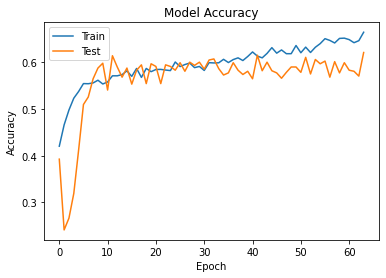

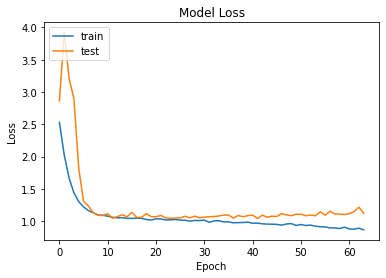

In [42]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Initial_Model_Accuracy.png')
plt.show()
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [43]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

28/28 [==============================] - 0s 3ms/step - loss: 1.1184 - accuracy: 0.6211
Loss of the model is -  1.118396520614624
28/28 [==============================] - 0s 3ms/step - loss: 1.1184 - accuracy: 0.6211
Accuracy of the model is -  62.11251616477966 %


In [44]:
predictions = model.predict(X_test)
predictions=predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

finaldf = actual.join(predictions)
finaldf[140:160]

,Actual Values,Predicted Values
140,angry,angry
141,neutral,neutral
142,sad,sad
143,sad,sad
144,angry,angry
145,neutral,neutral
146,neutral,neutral
147,neutral,neutral
148,sad,neutral
149,angry,angry


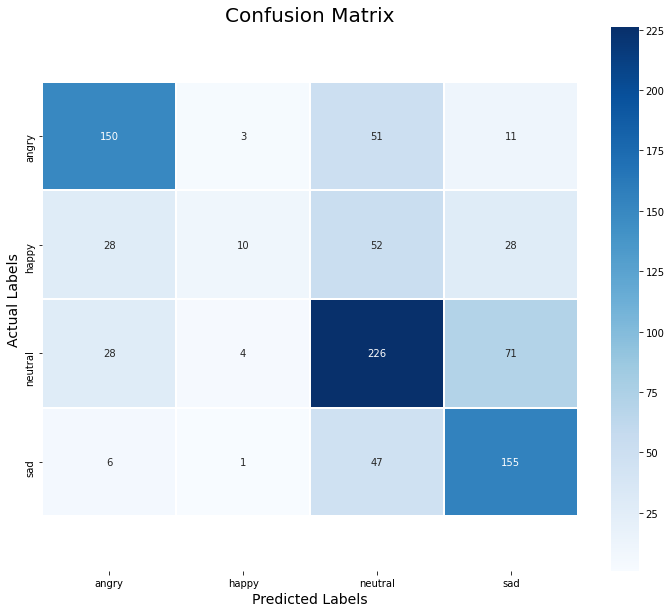

In [45]:
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()